PROBLEMAS: si ponemos q mb busque por "argentina", encuentra un rene perez argentino, pero si sacamos eso, emilia mernes es suiza... vamos a tener errores si o si. agrego esto acá para acordarnos para el informe.

In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import json
import re
from multiprocessing import Queue
import networkx as nx
import musicbrainzngs as mb 
import pickle
import numpy as np
import wikipedia as wiki
import time

In [15]:
mb.set_useragent('redes_complejas', 0.1) 

def conseguir_id(artista):
    # POST donde le pasamos las clave de la app
    response = requests.post('https://accounts.spotify.com/api/token', data = {'grant_type': 'client_credentials', 'client_id': CLIENT_ID, 'client_secret': CLIENT_SECRET})
    # Guardamos el bearer token para usarlo en las peticiones de la API
    access_token = response.json()['access_token']
    headers = {'Authorization': 'Bearer {}'.format(access_token), 'Accept': 'application/json', 'Content-Type': 'application/json'}

    """
    Recibe
        artista: Nombre del artista del cual se quiere su ID
    Devuelve:
        id: La ID del artista
    """
    # End point para obtener los audio features. Esto se saca de la referencia de la documentación
    url = 'https://api.spotify.com/v1/search'

    # Búsqueda. Acá sí hay que pasarselo como parámetros
    params = {'q': f"{artista}", 'type': 'artist', 'limit': '2'}

    # En este caso no lleva ningún parámetro, el id de la canción va directamente en el url
    response = requests.get(url, params = params, headers = headers)

    # Vemos el json de la respuesta
    json_data = response.json()
    
    # Con la siguiente lista conseguimos el ID del primer resultado de la busqueda (creo)
    id = json_data["artists"]["items"][0]["id"]

    return id


lista_artistas_provincia = np.load("artistas_por_provincia_wikipedia.npy")

def es_argentino_y_genero_provincia(nombre_artista): #devuelve true or false nada mas, si queremos mas cosas cambiarlo
    # Metemos a Argentina en la lista de provincias por las dudas ya que hay artistas que lo tienen
    es_arg = False
    genero = "NA"
    provincia = "NA"
    lista_provincias = ["Argentina","Buenos Aires", "Catamarca", "Chaco", "Chubut", "Córdoba", "Corrientes", "Entre Ríos", "Formosa", "Jujuy", "La Pampa", "La Rioja", "Mendoza", "Misiones", "Neuquén", "Río Negro", "Salta", "San Juan", "San Luis", "Santa Cruz", "Santa Fe", "Santiago del Estero", "Tierra del Fuego", "Tucumán"]
    data = mb.search_artists(artist = nombre_artista, limit= 1, country = "Argentina", area = "Argentina")
    print(data)
    if nombre_artista in lista_artistas_provincia: # Lo buscamos en nuestra lista de artistas
        es_arg = True
    
    if data["artist-count"] != 0: # Lo buscamos en musicbrandz
        if "country" in data["artist-list"][0]:
            pais = data["artist-list"][0]["country"]
            if pais == 'AR':
                es_arg = True
        # Comprobamos las provincias si no está el país
        elif "begin-area" in data["artist-list"][0]:
            provincia = data["artist-list"][0]["begin-area"]["name"]
            if provincia in lista_provincias:
                es_arg = True
        elif "area" in data["artist-list"][0]:
            # A veces la siguiente linea de donde conseguimos la provincia es Argentina, en ese caso no cambiamos la provincia
            if data["artist-list"][0]["area"]["name"] != "Argentina": 
                provincia = data["artist-list"][0]["area"]["name"]
                if provincia in lista_provincias:
                    es_arg = True
        
        else: # Lo buscamos en wikipedia
            try:
                primera_busqueda = wiki.search(nombre_artista)[0]
                pagina_wiki = wiki.WikipediaPage(primera_busqueda)
                for categorie in pagina_wiki.categories:
                    if "Argentine" in categorie:
                        es_arg = True
                        break
            except:
                pass

        if "gender" in data["artist-list"][0]:
            genero = data["artist-list"][0]["gender"]

    return es_arg, genero, provincia

# En la siguiente línea se define de donde se saca toda la info, como si este fuera el paquete
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = CLIENT_ID, client_secret=CLIENT_SECRET))

q = Queue()

def red_colaboradores_artista(nombre_artista, G):
    
    albums_revisados = []
    lista_colaboradores = []
    # Uri es como el id del artista pero para spotipy
    uri = "spotify:artist:" + conseguir_id(nombre_artista)
    # Conseguimos los albumes del artista
    results = sp.artist_albums(uri, album_type='album,single', country='AR')
    albums = results['items']

    # No se que hace bien todavia 
    while results['next']:
        # Depaginate
        results = sp.next(results)
        albums.extend(results['items'])

    # Hacemos un filtro a los albumes para que sean únicos
    real_albums = dict()

    for album in albums:
        
        # Strip extraneous characters
        name = re.sub(r'\([^)]*\)|\[[^)]*\]', '', album['name']) # remove (Deluxe edition) and [Feat. asdf] tags
        name = re.sub(r'\W','', name).lower().strip() # remove all non-alphanumerical characters
        if name not in real_albums:
            # print('Adding ' + name)
            real_albums[name] = album
            real_albums[name+"_fecha"] = album["release_date"]

    # Ciclamos sobre los albumes que son únicos
    for album in real_albums:
        # Chequeamos que no hayamos revisado el album
        if album not in albums_revisados:
            # Mark album as analyzed
            albums_revisados.append(album)
            # print('\tAlbum: ' + real_albums[album]['name'])

            # Obtenemos las canciones del album
            results = sp.album_tracks(real_albums[album]['id'])
            canciones = results['items']
            while results['next']:
                results = sp.next(results)
                canciones.extend(results['items'])

            # Recorremos las canciones
            for cancion in canciones:
                # Recorremos los artistas de la canción
                for artist in cancion['artists']:
                    # Chequeamos que no tengan igual uri
                    if artist['uri'] != uri:
                        # print('\t\t' + artist['name'])
                        # La siguiente línea no la entiendo bien, pero creo que lo que hace es el time.sleep que haciamos pero mejor
                        q.put(artist['uri'])
                        
                        es_argentino, genero_colaborador = es_argentino_y_genero_provincia(artist['name'])


                        if artist['uri'] not in G and es_argentino:
                            # Get detailed description of artist and create node
                            artist = sp.artist(artist['uri'])
                                # print(artist)
                            G.add_node(artist['name'], id=artist['uri'], popularidad=artist['popularity'], generos_musicales = artist['genres'], genero = genero_colaborador)
                            lista_colaboradores.append(artist['name'])
                            # # Try adding artist's image
                            # if len(artist['images']) > 0:
                            #     G.node[artist['uri']]['image_url'] = artist['images'][0]['url']
                            # else:
                            #     G.node[artist['uri']]['image_url'] = "https://developer.spotify.com/wp-content/uploads/2016/07/icon1@2x.png"
                        # Count how many collaborations
                            try:
                                G[artist['name']][nombre_artista]['freq'] += 1
                            except KeyError:
                                G.add_edge(artist['name'], nombre_artista, freq=1)
    return lista_colaboradores

def crear_red_ego(nombre_artista,G):
    lista_colaboradores = red_colaboradores_artista(nombre_artista, G)
    # for colaborador in lista_colaboradores:
    #     lista_colaborades_2 = red_colaboradores_artista(colaborador, G)
    #     for colaborador_2 in lista_colaboradores_2:
    #         if colaborador_2 not in lista_colaboradores:
    #             lista_colaboradores.append(colaborador_2)
        
    return G


In [5]:
client_ids = ['3a283f4bd64241238d019491e4aedca3',"5b52471dd4894ebbbbd0a5b63e33cf63","3a533c6fd3434a29a09896712d5c19bd","14c49fbcea5a4439bfa94aa591089353","8b3a74b411c14db295be20c03a164241","62dad7314da84b22b885bab72e7f2d60","c8a66e35cf214da89054ba73d3c6fa38","78d1a19d9dbd4672a6e404648a02a002", "90eac8c23ced4e508e3c24aa6963e9dd"]
client_secrets = ['aee8c6c05d0a42c487c0069b7bd075a8',"62730cfc96a54bc298c2587228ac147e", "65f9ad113dd54f6091cee7aa5498568b","710e61b1ca974449a6c7a23c50146cca","9078850544c14866b525ab61aa7dfdf2","7a346376cdaf43948b16b436ca62c8a9","88e65321317744a6bad17c0522a63756", "dfebc28a789d44b89ad0fdce779af0e2", "1c8c10c2b9d94934b733b26fd06a3783"]

In [6]:
nombre_artista = "Duki"
tiempo_inicial = time.time()
index_aut = 1
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = client_ids[index_aut], client_secret=client_secrets[index_aut]))
# Definimos un multigrafo
G = nx.MultiGraph()


# Tags de canciones a revisar

filtro_canciones = ["en vivo","en directo","live from","live"] 

# Artists that have been examined
lista_artistas = [nombre_artista]
lista_provincias = [] 
# Albums that have been examined
albums_revisados = []


i = 0
while time.time()-tiempo_inicial < 60*1:

    try:
        # Uri es como el id del artista pero para spotipy
        uri = "spotify:artist:" + conseguir_id(lista_artistas[i])
        # Conseguimos los albumes del artista
        results = sp.artist_albums(uri, album_type='album,single', country='AR') # Esto algo filtra tambien
        albums = results['items']
        canciones_revisadas = [] #agrego esto para que no se tengan en cuenta dos canciones subidas dos veces. puede fallar si el artista hacer cover con dos artistas en dos veces diferentes.
        # No se que hace bien todavia 
        while results['next']:
            # Depaginate
            results = sp.next(results)
            albums.extend(results['items'])

        
        real_albums = dict()
        # Hacemos un filtro a los albumes para que sean únicos
        for album in albums:
            # Strip extraneous characters
            name = re.sub(r'\([^)]*\)|\[[^)]*\]', '', album['name']) # remove (Deluxe edition) and [Feat. asdf] tags
            name = re.sub(r'\W','', name).lower().strip() # remove all non-alphanumerical characters
            if name not in real_albums:
                # print('Adding ' + name)
                real_albums[name] = album
                
                
        # Ciclamos sobre los albumes que son únicos
        for album in real_albums:
            
            # Chequeamos que no hayamos revisado el album
            if album not in albums_revisados:
                # album es un string con el nombre del album
                fecha_album = real_albums[album]['release_date']
                # Mark album as analyzed
                albums_revisados.append(album)
                # print('\tAlbum: ' + real_albums[album]['name'])

                # Obtenemos las canciones del album
                results = sp.album_tracks(real_albums[album]['id'])
                canciones = results['items']
                while results['next']:
                    results = sp.next(results)
                    canciones.extend(results['items'])

                # Recorremos las canciones
                for cancion in canciones:
                    if cancion["name"] not in canciones_revisadas:
                        for palabra_filtro in filtro_canciones:
                            if palabra_filtro not in cancion["name"].lower():
                                # Recorremos los artistas de la canción
                                for artist in cancion['artists']:
                                    # Chequeamos que no tengan igual uri
                                    if artist['uri'] != uri:
                                        # print('\t\t' + artist['name'])
                                        # La siguiente línea no la entiendo bien, pero creo que lo que hace es el time.sleep que haciamos pero mejor
                                        q.put(artist['uri'])
                                        es_argentino, genero_colaborador, provincia = es_argentino_y_genero_provincia(artist['name'])

                                        if es_argentino:
                                            if artist['uri'] not in G:
                                                # Get detailed description of artist and create node
                                                artist = sp.artist(artist['uri'])
                                                # print(artist)
                                                # Agregamos atributos al nodo
                                                G.add_node(artist['name'], id=artist['uri'], popularidad=artist['popularity'], generos_musicales = artist['genres'], 
                                                            genero = genero_colaborador, provincia = provincia)
                                                lista_artistas.append(artist['name'])
                                                # # Try adding artist's image
                                                # if len(artist['images']) > 0:
                                                #     G.node[artist['uri']]['image_url'] = artist['images'][0]['url']
                                                # else:
                                                #     G.node[artist['uri']]['image_url'] = "https://developer.spotify.com/wp-content/uploads/2016/07/icon1@2x.png"
                                        # Count how many collaborations
                                            # Siempre agrego enlace ya que tiene en cuenta el tiempo
                                            G.add_edge(artist['name'], lista_artistas[i], nombre = cancion["name"] ,fecha = fecha_album)
                    print(f"{cancion['name']} esta repetida")
        i += 1
        
    except:

        index_aut += 1
        if index_aut == len(client_ids):
            index_aut = 0
        sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = client_ids[index_aut], client_secret=client_secrets[index_aut]))




Todavia Cantamos - En Vivo
Gracias a La Vida - En Vivo
Pedro Canoero - En Vivo
Naomi - En Vivo
Vuelvo Al Sur - En Vivo
Razon De Vivir - En Vivo
Cuando Me Acuerdo De Mi Pais - En Vivo
Todo Cambia - En Vivo
Al Jardin De La Republica - En Vivo
Entre a Mi Pago Sin Golpear - En Vivo
Oh, Que Sera - En Vivo
Solo Le Pido a Dios - En Vivo
Honrar La Vida - En Vivo
Dale Alegfria a Mi Corazon - En Vivo
Como la Cigarra - En Vivo
Yo Vengo a Ofrecer Mi Corazón - En Vivo
Me Haces Bien - En Vivo
Piedra y Camino - En Vivo
Deja la Vida Volar - En Vivo
Guitarra Dímelo Tu - En Vivo
Gente Humilde - En Vivo
Alfonsina y el Mar - En Vivo
Agua, Fuego, Tierra y Viento - En Vivo
Vuelvo al Sur - En Vivo
Los Mareados - En Vivo
Aquellas Pequeñas Cosas - En Vivo
La Celedonia Batista - En Vivo
María María - En Vivo
De Mí / María María - Popurrí En Vivo
María Va - En Directo
Sueño Con Serpientes - En Directo
Al Jardín De La Republica - En Directo
La Arenosa - En Directo
Años - En Directo
Sueño Con Serpientes - En Direc

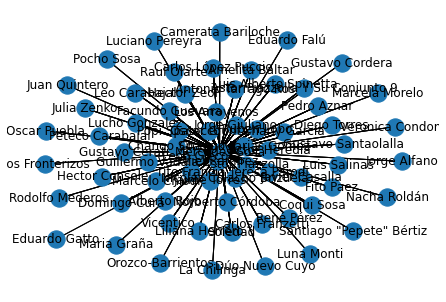

In [7]:
nx.draw(G, with_labels = True)

In [ ]:
lista = []
for node in G.nodes():
    lista.append(G.nodes()[node]["provincia"])

lista = np.unique(lista)

Ejemplo de como se agregan los multienlaces

In [38]:
G = nx.MultiGraph()

# Funciona con numeros y strings por igual
G.add_edge("jorge",2, color = "12")
G.add_edge("jorge",2, color = 'messi')

G["jorge"][2]

AtlasView({0: {'color': '12'}, 1: {'color': 'messi'}})

In [39]:
G.degree()

MultiDegreeView({'jorge': 2, 2: 2})

In [86]:
lista_artistas, red = crear_red_ego("bizarrap",1)

In [87]:
red["bizarrap"]["Duki"]

AtlasView({0: {'fecha': '2021-12-01'}, 1: {'fecha': '2021-10-14'}, 2: {'fecha': '2021-07-28'}, 3: {'fecha': '2019-12-13'}})

In [88]:
red.degree()

MultiDegreeView({'Paulo Londra': 1, 'bizarrap': 48, 'Trueno': 4, 'L-Gante': 2, 'Pablo Lescano': 1, 'Tiago PZK': 1, 'Duki': 4, 'Nicki Nicole': 3, 'YSY A': 2, 'Dread Mar I': 1, 'Asan': 1, 'ACRU': 1, 'KHEA': 1, 'Seven Kayne': 1, 'Cazzu': 1, 'ZARAMAY': 1, 'Homer El Mero Mero': 1, 'LIT killah': 2, 'Lucho SSJ': 1, 'Dani Ribba': 2, 'Pekeño 77': 2, 'LOUTA': 1, 'Frijo': 2, 'CA7RIEL': 1, 'Kiddo Toto': 1, 'Dillom': 1, 'Kodigo': 3, 'Blunted Vato': 1, 'Paco Amoroso': 1, 'Axel Fiks': 1, 'Halpe': 2, 'XOVOX': 1})

Para guardar la red

In [ ]:
pickle.dump(lista_artistas, open(f'lista artistas argentinos_{i}', 'wb'))
nx.write_gexf(red, f"red_final_{i}.gexf")